In [36]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 1000
import os
import seaborn as sns
import matplotlib.pyplot as plt

**Data Cleaning**

In [37]:
file_path = '../data/TDBRAIN_participants_V2.tsv'
df = pd.read_csv(file_path, sep='\t')

# remove last three rows because they're all empty
df = df[:-3]

# remove replication rows
print("shape before removing replication rows:", df.shape)
df = df[df['DISC/REP'] != 'REPLICATION']
print("shape after removing replication rows:", df.shape)

# remove last col since unnamed
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

df

shape before removing replication rows: (1347, 111)
shape after removing replication rows: (1227, 111)


,participants_ID,DISC/REP,indication,formal_status,Dataset,Consent,sessSeason,sessTime,Responder,Remitter,...,BDI_pre,BDI_post,rTMS PROTOCOL,ADHD_pre_Hyp_leading,ADHD_pre_Att_leading,ADHD_post_Att_leading,ADHD_post_Hyp_leading,NF Protocol,YBOCS_pre,YBOCS_post
120,sub-87963457,DISCOVERY,BURNOUT,BURNOUT,NaN,YES,spring,afternoon,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,sub-87963593,DISCOVERY,BURNOUT,BURNOUT,NaN,YES,spring,morning,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,sub-87963725,DISCOVERY,SMC,UNKNOWN,NaN,YES,summer,afternoon,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,sub-87963769,DISCOVERY,SMC,UNKNOWN,NaN,YES,summer,afternoon,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,sub-87964717,DISCOVERY,SMC,UNKNOWN,NaN,YES,summer,afternoon,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,sub-88078657,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,fall,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1343,sub-88078749,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,winter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1344,sub-88078793,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,winter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1345,sub-88078837,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,winter,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
print(df.dtypes)

participants_ID           object
DISC/REP                  object
indication                object
formal_status             object
Dataset                   object
Consent                   object
sessSeason                object
sessTime                  object
Responder                 object
Remitter                  object
age                       object
gender                   float64
sessID                   float64
nrSessions               float64
EC                       float64
EO                       float64
neoFFI_q1                 object
neoFFI_q2                 object
neoFFI_q3                 object
neoFFI_q4                 object
neoFFI_q5                 object
neoFFI_q6                 object
neoFFI_q7                 object
neoFFI_q8                 object
neoFFI_q9                 object
neoFFI_q10                object
neoFFI_q11                object
neoFFI_q12                object
neoFFI_q13                object
neoFFI_q14                object
neoFFI_q15

In [39]:
df = pd.read_csv(file_path, sep='\t')
df = df[:-3]
df = df[df["DISC/REP"] != "REPLICATION"]
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df = df.reset_index(drop=True)
print(df.shape)

# rename columns
df = df.rename(columns={"Weight (kg)": "weight", "Height (cm)": "height", "rTMS PROTOCOL": "rTMS_protocol", "NF Protocol": "NF_protocol"})

# convert columns from str to float (commas -> periods) (e.g. 51,59 -> 51.59)
print(df["age"][1])
cols = [c for c in ["age", "BDI_pre", "BDI_post", "well", "vision", "hearing", "weight", "height", "education"]]
df[cols] = (
    df[cols]
    .astype(str)
    .apply(lambda s: s.str.replace(",", ".", regex=False))
    .apply(pd.to_numeric, errors="coerce")
)
print(df["age"][1])

cols = [c for c in df.columns if c.startswith(("n_", "avg_", "neoFFI_", "ADHD_", "YBOCS_"))]
df[cols] = (
    df[cols]
    .astype(str)
    .apply(lambda s: s.str.replace(",", ".", regex=False))
    .apply(pd.to_numeric, errors="coerce")
)
print(df.shape)

(1227, 110)
52,9
52.9
(1227, 110)


In [40]:
# process "hours ago/never" variables
columns_to_process = ["cigarette", "coffee", "beer", "drugs", "meal", "sleep"]

new_cols = []
for col in columns_to_process:
    numeric_col = pd.to_numeric(df[col], errors="coerce")
    
    # create two new columns
    ever_used = np.where(numeric_col.isna(), np.nan, (numeric_col != 99).astype(int))
    hours_since = numeric_col.replace(99, np.nan)
    
    # store them in new_cols
    new_cols.append(pd.DataFrame({
        f"ever_used_{col}": ever_used,
        f"hours_since_last_{col}": hours_since
    }))

# concat all new columns at once
df = pd.concat([df] + new_cols, axis=1)

# drop original columns
df = df.drop(columns=columns_to_process)

# drop meaningless columns
df = df.drop(columns=["ever_used_sleep", "ever_used_meal"])

print("final shape:", df.shape)
df

final shape: (1227, 114)


,participants_ID,DISC/REP,indication,formal_status,Dataset,Consent,sessSeason,sessTime,Responder,Remitter,...,ever_used_cigarette,hours_since_last_cigarette,ever_used_coffee,hours_since_last_coffee,ever_used_beer,hours_since_last_beer,ever_used_drugs,hours_since_last_drugs,hours_since_last_meal,hours_since_last_sleep
0,sub-87963457,DISCOVERY,BURNOUT,BURNOUT,NaN,YES,spring,afternoon,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,3.0,9.0
1,sub-87963593,DISCOVERY,BURNOUT,BURNOUT,NaN,YES,spring,morning,NaN,NaN,...,0.0,NaN,1.0,9.0,1.0,10.0,1.0,0.0,3.0,7.0
2,sub-87963725,DISCOVERY,SMC,UNKNOWN,NaN,YES,summer,afternoon,NaN,NaN,...,0.0,NaN,1.0,9.0,1.0,15.0,1.0,0.0,1.0,3.0
3,sub-87963769,DISCOVERY,SMC,UNKNOWN,NaN,YES,summer,afternoon,NaN,NaN,...,0.0,NaN,1.0,9.0,1.0,15.0,1.0,0.0,4.0,5.0
4,sub-87964717,DISCOVERY,SMC,UNKNOWN,NaN,YES,summer,afternoon,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,sub-88078657,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,fall,NaN,NaN,NaN,...,0.0,NaN,1.0,9.0,1.0,10.0,0.0,NaN,3.0,5.0
1223,sub-88078749,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,winter,NaN,NaN,NaN,...,0.0,NaN,1.0,9.0,0.0,NaN,0.0,NaN,2.0,5.0
1224,sub-88078793,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,winter,NaN,NaN,NaN,...,0.0,NaN,1.0,9.0,1.0,15.0,0.0,NaN,2.0,7.0
1225,sub-88078837,DISCOVERY,INSOMNIA,INSOMNIA,NaN,YES,winter,NaN,NaN,NaN,...,1.0,5.0,1.0,5.0,0.0,NaN,0.0,NaN,4.0,9.0


In [41]:
# clean up target vars
df["Remitter"] = df["Remitter"].replace(["/nan", "nan"], np.nan)
df["Remitter"] = pd.to_numeric(df["Remitter"], errors="coerce").astype("Int64")

df["Responder"] = pd.to_numeric(df["Responder"], errors="coerce").astype("Int64")

In [42]:
print(df.dtypes)

participants_ID                object
DISC/REP                       object
indication                     object
formal_status                  object
Dataset                        object
Consent                        object
sessSeason                     object
sessTime                       object
Responder                       Int64
Remitter                        Int64
age                           float64
gender                        float64
sessID                        float64
nrSessions                    float64
EC                            float64
EO                            float64
neoFFI_q1                     float64
neoFFI_q2                     float64
neoFFI_q3                     float64
neoFFI_q4                     float64
neoFFI_q5                     float64
neoFFI_q6                     float64
neoFFI_q7                     float64
neoFFI_q8                     float64
neoFFI_q9                     float64
neoFFI_q10                    float64
neoFFI_q11  

**EDA**

In [43]:
# create folder for eda figures
os.makedirs("../figures/EDA", exist_ok=True)

In [44]:
# display missing values count for each col
print('Count of missing values in each column:')
print(df.isnull().sum())

Count of missing values in each column:
participants_ID                  0
DISC/REP                         0
indication                     259
formal_status                   24
Dataset                        982
Consent                          0
sessSeason                      30
sessTime                      1078
Responder                      997
Remitter                      1001
age                             21
gender                           0
sessID                           0
nrSessions                       0
EC                               0
EO                               0
neoFFI_q1                      324
neoFFI_q2                      324
neoFFI_q3                      324
neoFFI_q4                      324
neoFFI_q5                      324
neoFFI_q6                      324
neoFFI_q7                      324
neoFFI_q8                      324
neoFFI_q9                      324
neoFFI_q10                     324
neoFFI_q11                     324
neoFFI_q12     

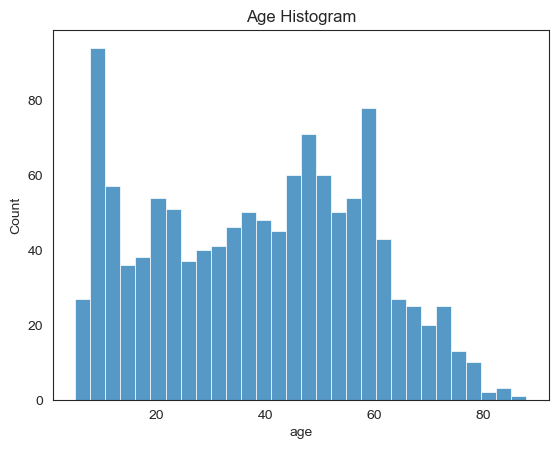

In [45]:
# age histogram
age_col = df['age']
sns.set_style("white")
sns.histplot(data=age_col, bins=30, linewidth=0.5)
plt.title("Age Histogram")
plt.show()

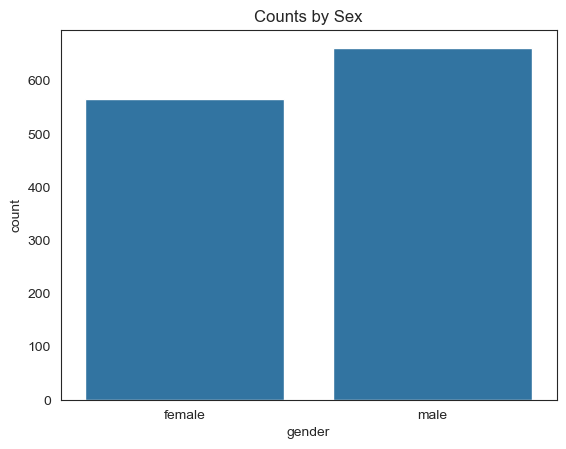

In [46]:
# sex bar plot
sns.countplot(x="gender", data=df)
plt.xticks(ticks=[0, 1], labels=["female", "male"])
plt.title("Counts by Sex")
plt.show()

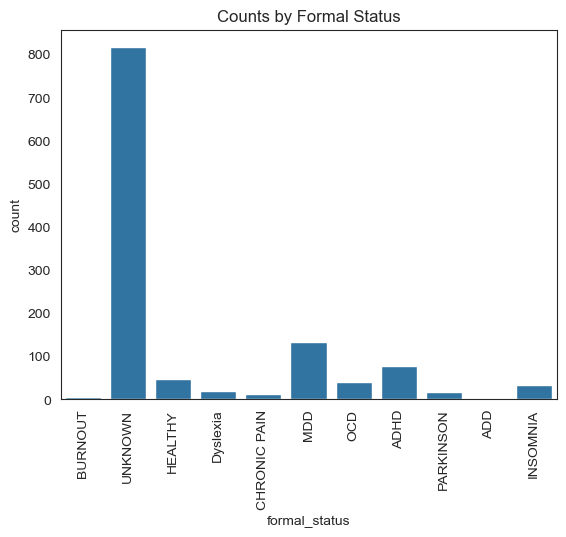

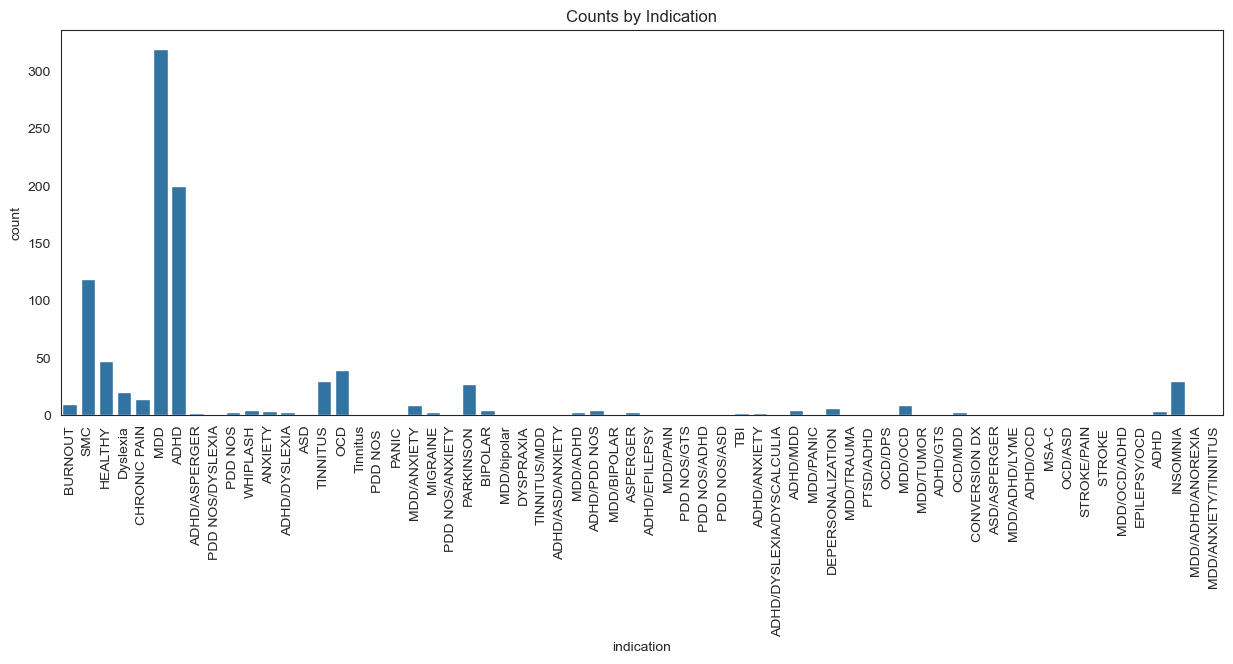

In [47]:
# indication and formal dx bar plot
sns.countplot(x="formal_status", data=df)
plt.title("Counts by Formal Status")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,5))
sns.countplot(x="indication", data=df)
plt.title("Counts by Indication")
plt.xticks(rotation=90)
plt.show()

[nan  0. 13. 15. 10.  7.]
[nan 20. 47. 21. 42. 16. 30. 36. 43. 55. 52. 38. 33. 29. 14. 18. 45. 17.
 22. 34. 28. 37. 26. 40. 31. 41. 35. 15. 44. 23. 27. 49. 24. 19.  8.  4.
 25. 48. 56.  2. 50.  0. 32. 51.  9. 39. 10.  1. 13.]


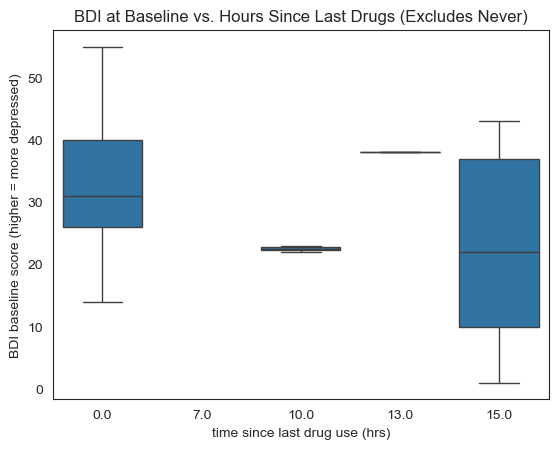

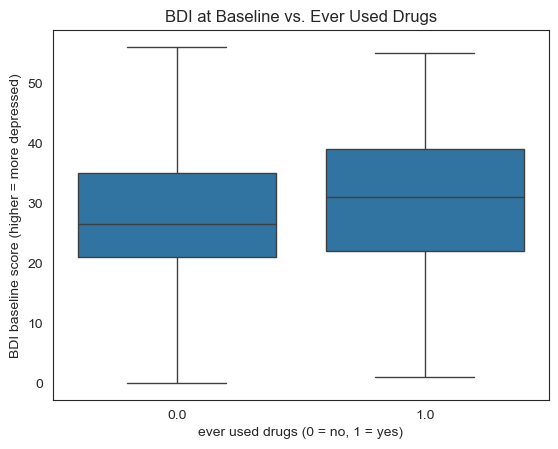

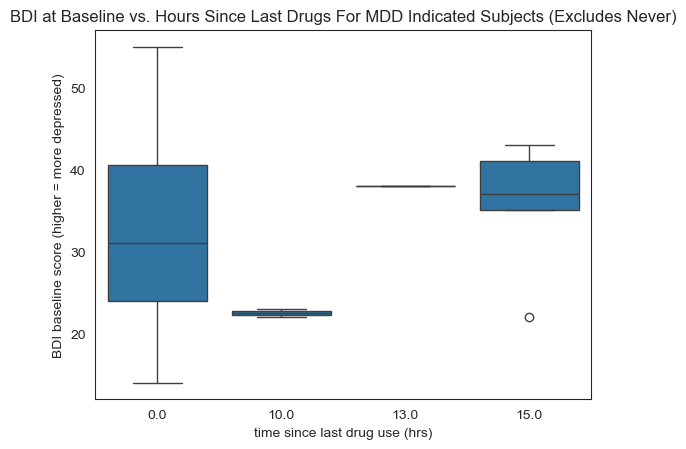

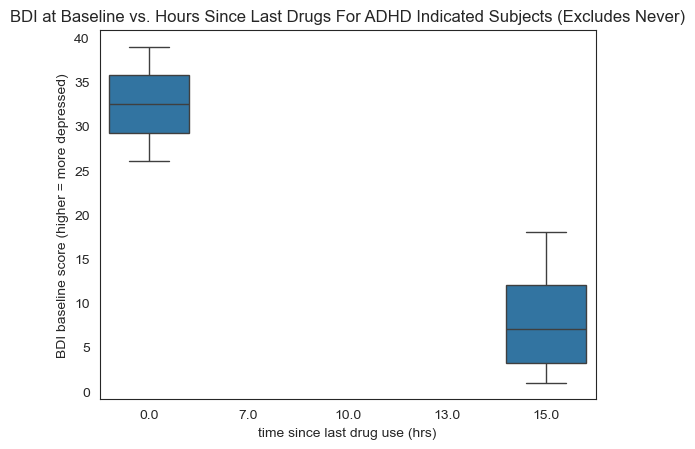

In [48]:
# boxplots of clinical depression scores vs. drug use
print(df["hours_since_last_drugs"].unique())
print(df["BDI_pre"].unique())

sns.boxplot(x="hours_since_last_drugs", y="BDI_pre", data=df)
plt.xlabel("time since last drug use (hrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Hours Since Last Drugs (Excludes Never)")
plt.show()

sns.boxplot(x="ever_used_drugs", y="BDI_pre", data=df)
plt.xlabel("ever used drugs (0 = no, 1 = yes)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Ever Used Drugs")
plt.show()

# look only at MDD indicated subjects
df_MDD_indicated = df[df["indication"]=="MDD"]
sns.boxplot(x="hours_since_last_drugs", y="BDI_pre", data=df_MDD_indicated)
plt.xlabel("time since last drug use (hrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Hours Since Last Drugs For MDD Indicated Subjects (Excludes Never)")
plt.show()

# look only at ADHD indicated subjects
df_ADHD_indicated = df[df["indication"]=="ADHD"]
sns.boxplot(x="hours_since_last_drugs", y="BDI_pre", data=df_ADHD_indicated)
plt.xlabel("time since last drug use (hrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Hours Since Last Drugs For ADHD Indicated Subjects (Excludes Never)")
plt.show()

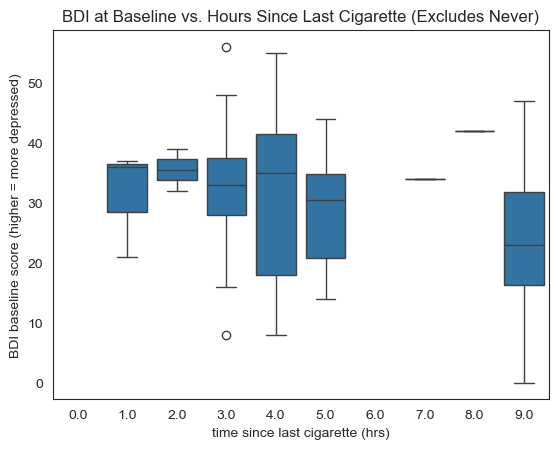

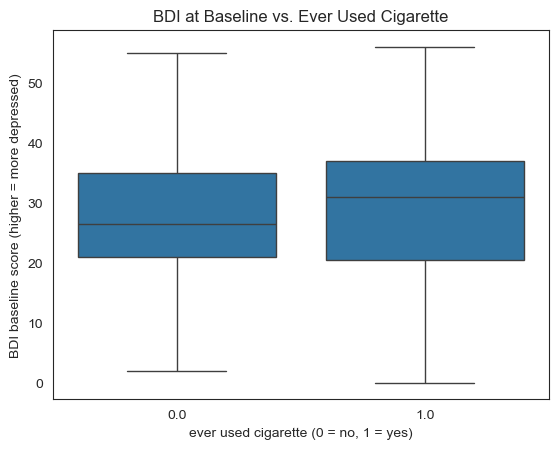

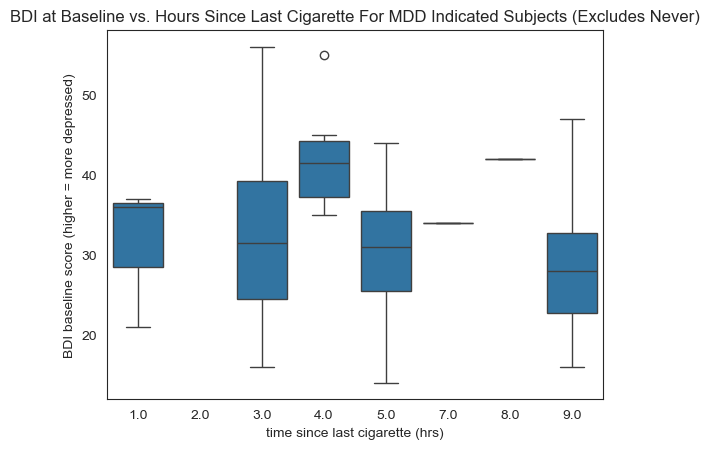

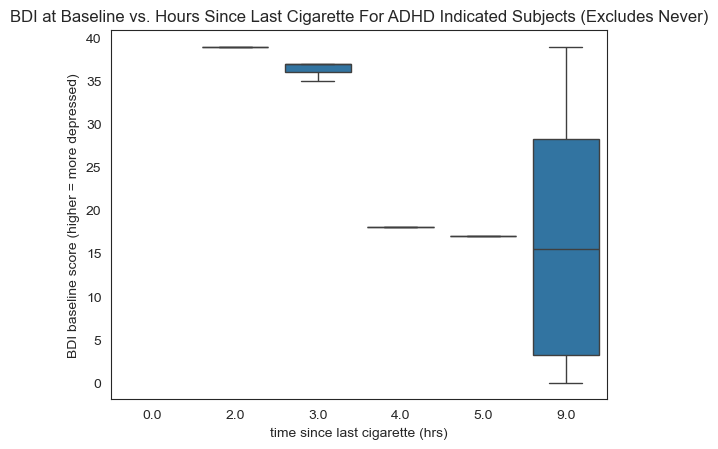

In [49]:
# boxplot of clinical depression scores vs. cigarettes
sns.boxplot(x="hours_since_last_cigarette", y="BDI_pre", data=df)
plt.xlabel("time since last cigarette (hrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Hours Since Last Cigarette (Excludes Never)")
plt.show()

sns.boxplot(x="ever_used_cigarette", y="BDI_pre", data=df)
plt.xlabel("ever used cigarette (0 = no, 1 = yes)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Ever Used Cigarette")
plt.show()

# look only at MDD indicated subjects
sns.boxplot(x="hours_since_last_cigarette", y="BDI_pre", data=df_MDD_indicated)
plt.xlabel("time since last cigarette (hrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Hours Since Last Cigarette For MDD Indicated Subjects (Excludes Never)")
plt.show()

# look only at ADHD indicated subjects
sns.boxplot(x="hours_since_last_cigarette", y="BDI_pre", data=df_ADHD_indicated)
plt.xlabel("time since last cigarette (hrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Hours Since Last Cigarette For ADHD Indicated Subjects (Excludes Never)")
plt.show()

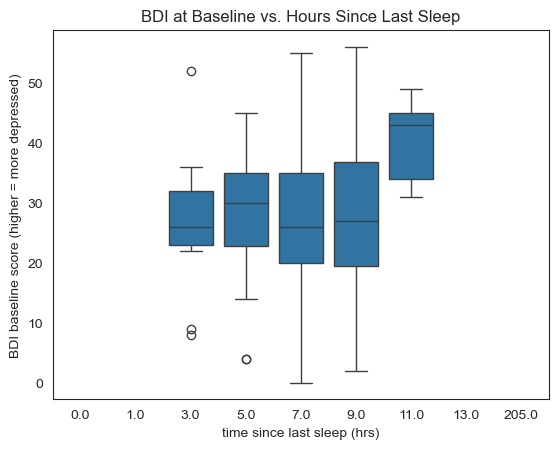

In [50]:
# boxplot of clinical depression scores vs. sleep
sns.boxplot(x="hours_since_last_sleep", y="BDI_pre", data=df)
plt.xlabel("time since last sleep (hrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Hours Since Last Sleep")
plt.show()

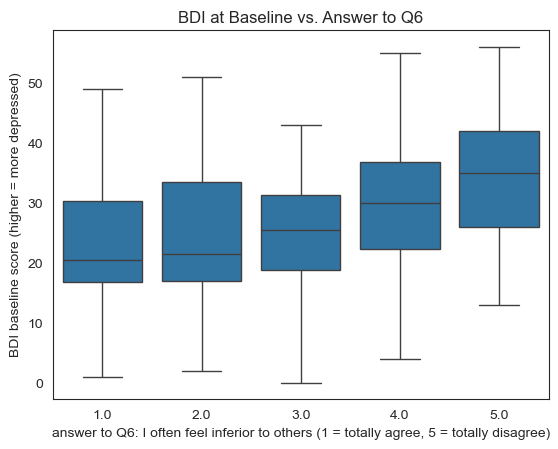

In [51]:
# boxplot of clinical depression scores vs. big5 q's
sns.boxplot(x="neoFFI_q6", y="BDI_pre", data=df)
plt.xlabel("answer to Q6: I often feel inferior to others (1 = totally agree, 5 = totally disagree)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Answer to Q6")
plt.show()

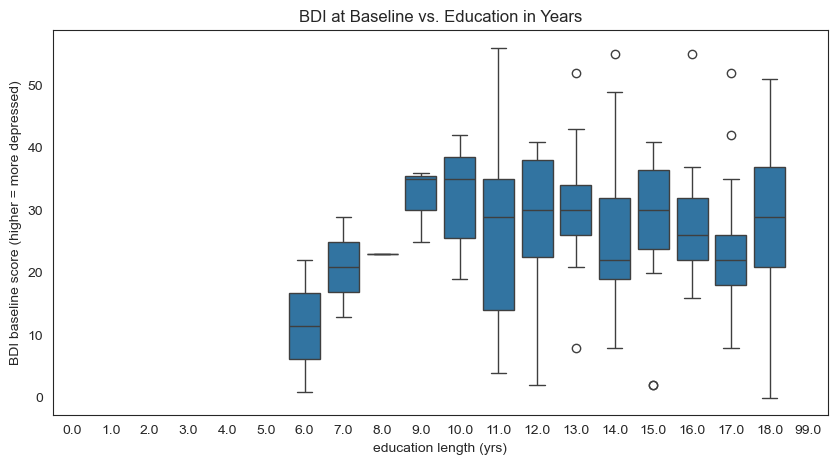

In [52]:
# scatterplot with education
plt.figure(figsize=(10,5))
sns.boxplot(x="education", y="BDI_pre", data=df)
plt.xlabel("education length (yrs)")
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Education in Years")
plt.show()

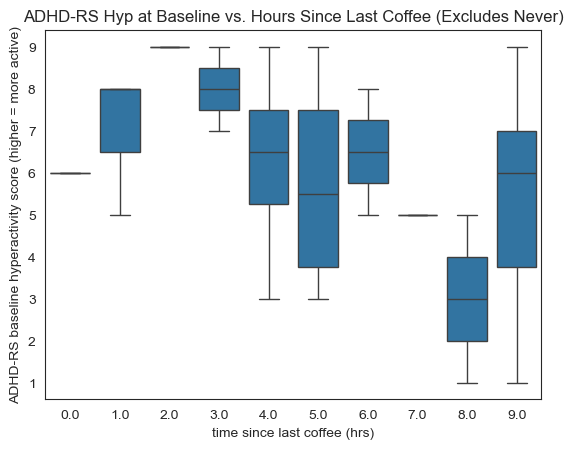

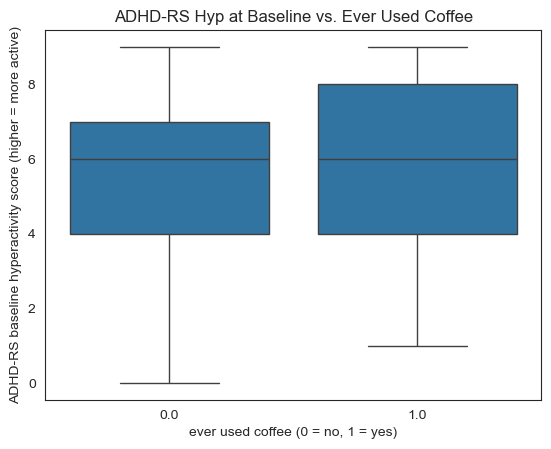

In [53]:
# boxplots of adhd-pre scores vs. coffee use
sns.boxplot(x="hours_since_last_coffee", y="ADHD_pre_Hyp_leading", data=df)
plt.xlabel("time since last coffee (hrs)")
plt.ylabel("ADHD-RS baseline hyperactivity score (higher = more active)")
plt.title("ADHD-RS Hyp at Baseline vs. Hours Since Last Coffee (Excludes Never)")
plt.show()

sns.boxplot(x="ever_used_coffee", y="ADHD_pre_Hyp_leading", data=df)
plt.xlabel("ever used coffee (0 = no, 1 = yes)")
plt.ylabel("ADHD-RS baseline hyperactivity score (higher = more active)")
plt.title("ADHD-RS Hyp at Baseline vs. Ever Used Coffee")
plt.show()

In [54]:
# target variable(s) eda
print(df["Remitter"].value_counts())
print(df["Responder"].value_counts())
print("\nPercentage of missing values:")
print(df[["Remitter", "Responder"]].isnull().sum()/df.shape[0])

Remitter
1    126
0    100
Name: count, dtype: Int64
Responder
1    163
0     67
Name: count, dtype: Int64

Percentage of missing values:
Remitter     0.815811
Responder    0.812551
dtype: float64


In [55]:
print(df["Dataset"].value_counts())

Dataset
MDD-rTMS       132
ADHD_NF         71
OCD             41
ADHD_NF/OCD      1
Name: count, dtype: int64


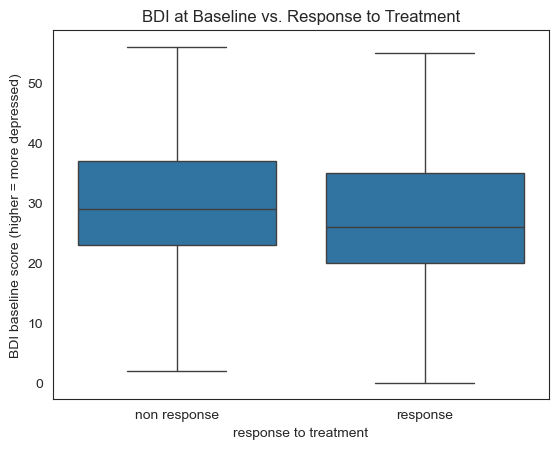

In [56]:
# BDI
sns.boxplot(x="Responder", y="BDI_pre", data=df)
plt.xlabel("response to treatment")
plt.xticks([0,1], labels=["non response", "response"])
plt.ylabel("BDI baseline score (higher = more depressed)")
plt.title("BDI at Baseline vs. Response to Treatment")
plt.show()

# sns.boxplot(x="Responder", y="BDI_pre", data=df_MDD_indicated)
# plt.xlabel("response to treatment")
# plt.xticks([0,1], labels=["non response", "response"])
# plt.ylabel("BDI baseline score (higher = more depressed)")
# plt.title("BDI at Baseline vs. Response to Treatment for MDD Indicated Subjects")
# plt.show()

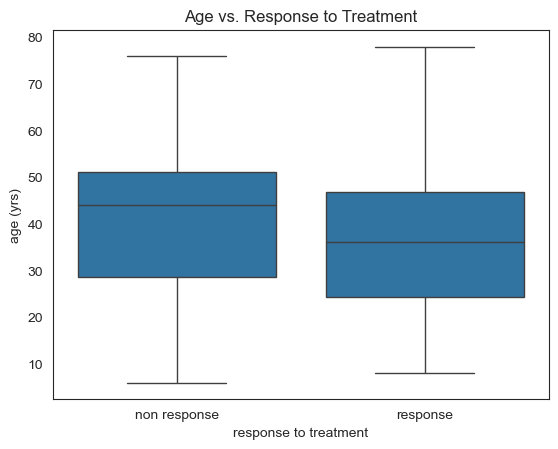

In [57]:
# age
sns.boxplot(x="Responder", y="age", data=df)
plt.xlabel("response to treatment")
plt.xticks([0,1], labels=["non response", "response"])
plt.ylabel("age (yrs)")
plt.title("Age vs. Response to Treatment")
plt.show()

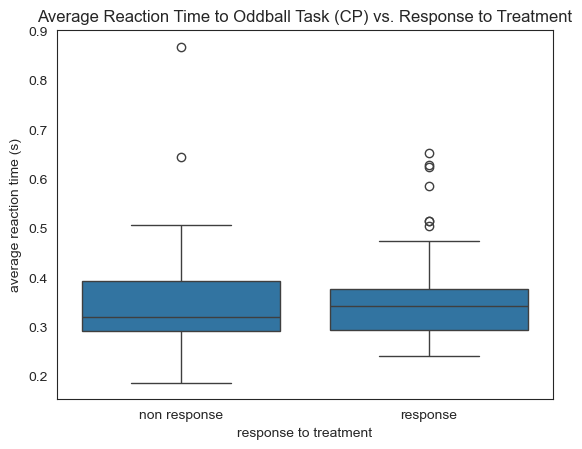

In [58]:
# average rt
sns.boxplot(x="Responder", y="avg_rt_oddb_CP", data=df)
plt.xlabel("response to treatment")
plt.xticks([0,1], labels=["non response", "response"])
plt.ylabel("average reaction time (s)")
plt.title("Average Reaction Time to Oddball Task (CP) vs. Response to Treatment")
plt.show()

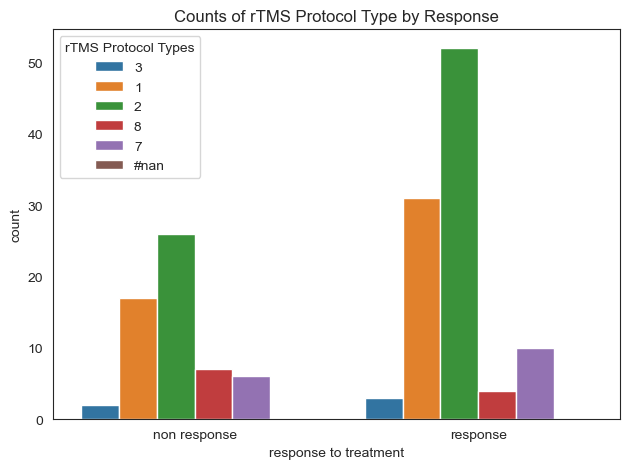

[nan '1' '3' '2' '7' '#nan' '8']


In [59]:
sns.countplot(
    data=df,
    x="Responder", 
    hue="rTMS_protocol"
)
plt.xlabel("response to treatment")
plt.xticks([0,1], labels=["non response", "response"])
plt.ylabel("count")
plt.title("Counts of rTMS Protocol Type by Response")
plt.legend(title="rTMS Protocol Types")
plt.tight_layout()
plt.show()

print(df["rTMS_protocol"].unique())

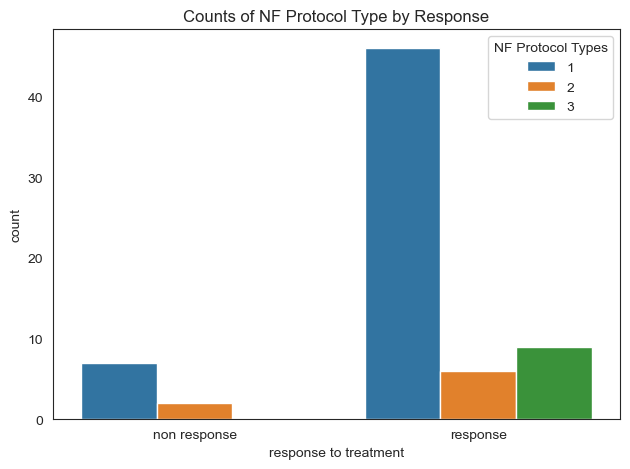

In [60]:
sns.countplot(
    data=df,
    x="Responder", 
    hue="NF_protocol"
)
plt.xlabel("response to treatment")
plt.xticks([0,1], labels=["non response", "response"])
plt.ylabel("count")
plt.title("Counts of NF Protocol Type by Response")
plt.legend(title="NF Protocol Types")
plt.tight_layout()
plt.show()

In [66]:
df_remitter = df[df["Remitter"].notna()]
print(df_remitter.shape)
print("\nCount of missing values after removing missing cases:")
missing_counts = df_remitter.isnull().sum()
missing_counts_sorted = missing_counts.sort_values() # sort
print(missing_counts_sorted)
df_remitter.to_csv("../data/final_dataset_remitter.csv", index=False)

(226, 114)

Count of missing values after removing missing cases:
participants_ID                 0
n_oddb_FP                       0
n_oddb_CN                       0
n_oddb_FN                       0
EO                              0
EC                              0
nrSessions                      0
n_oddb_CP                       0
gender                          0
sessID                          0
Responder                       0
sessSeason                      0
Consent                         0
Dataset                         0
DISC/REP                        0
Remitter                        0
ever_used_cigarette             1
ever_used_coffee                1
hearing                         1
vision                          1
well                            1
education                       1
ever_used_beer                  1
ever_used_drugs                 1
hours_since_last_meal           1
hours_since_last_sleep          1
indication                      1
age             

In [65]:
df_responder = df[df["Responder"].notna()]
print(df_responder.shape)
print("\nCount of missing values after removing missing cases:")
missing_counts = df_responder.isnull().sum()
missing_counts_sorted = missing_counts.sort_values() # sort
print(missing_counts_sorted)
df_responder.to_csv("../data/final_dataset_responder.csv", index=False)

(230, 114)

Count of missing values after removing missing cases:
participants_ID                 0
n_oddb_FP                       0
n_oddb_CN                       0
n_oddb_FN                       0
EO                              0
EC                              0
nrSessions                      0
sessID                          0
n_oddb_CP                       0
gender                          0
Responder                       0
sessSeason                      0
Consent                         0
Dataset                         0
DISC/REP                        0
hearing                         1
ever_used_coffee                1
vision                          1
well                            1
education                       1
ever_used_beer                  1
ever_used_drugs                 1
ever_used_cigarette             1
hours_since_last_meal           1
hours_since_last_sleep          1
indication                      1
age                             1
Remitter        